# Business Problem

Business Problem :: To Creating a more objective and fair process for goal setting!!

We have data from 4 data sources namely : 
1) account quarter :: each account in every quarter since Q1
2) account assignments :: each account and shows the unique identifier of the rep assigned to work with the account
3) reps => entry for each rep and shows their unique identifier
4) teams => an entry for each team

We will explore all dataset and identify rep level goals, team-level goal and aggregate goals for quarter 2 2021.


## Loading Data Files and Packages

In [283]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import pylab as py 
%matplotlib inline

In [284]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

In [285]:
excel="/Users/shaivya/Desktop/Data_Science_HW_Data.xlsx"

In [286]:
account = pd.read_excel(excel)

In [287]:
acct_assgn = pd.read_excel(excel, sheet_name=1)

In [288]:
reps = pd.read_excel(excel, sheet_name=2)

In [289]:
teams = pd.read_excel(excel, sheet_name=3)

In [291]:
#account.dtypes
#acct_assgn.dtypes
#reps.dtypes
#teams.dtypes

## Look at Representatives level 

In [292]:
account.describe()

,account_id,start_arr,expansion_arr
count,3600.000000,3600.000000,3400.000000
mean,100.500000,66552.805627,2791.467651
std,57.742326,70005.242153,12852.686209
min,1.000000,100.000000,0.000000
25%,50.750000,9037.703818,0.000000
50%,100.500000,18745.297250,0.000000
75%,150.250000,121055.581251,0.000000
max,200.000000,378000.346580,158477.701708


We observe account quarter is the main data file we will go ahead and join acct_assign,reps, teams table 
lets join account and rep tables and firstly extract values from date column 

In [293]:
account_acct_assgn=pd.merge(account,acct_assgn,on='account_id',how='left')

In [294]:
account_acct_assgn

,account_id,quarter,start_subscription_type,start_arr,expansion_arr,rep_id
0,1,2017-01-01,team,8172.226700,0.0,1
1,1,2017-04-01,team,8172.226700,0.0,1
2,1,2017-07-01,team,8172.226700,0.0,1
3,1,2017-10-01,team,8172.226700,0.0,1
4,1,2018-01-01,team,8172.226700,0.0,1
...,...,...,...,...,...,...
3595,200,2020-04-01,enterprise,231202.606738,0.0,10
3596,200,2020-07-01,team,231202.606738,0.0,10
3597,200,2020-10-01,team,6864.543108,0.0,10
3598,200,2021-01-01,team,6864.543108,0.0,10


In [295]:
print(account_acct_assgn.shape)
print(account_acct_assgn.info())

(3600, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3600 entries, 0 to 3599
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   account_id               3600 non-null   int64         
 1   quarter                  3600 non-null   datetime64[ns]
 2   start_subscription_type  3600 non-null   object        
 3   start_arr                3600 non-null   float64       
 4   expansion_arr            3400 non-null   float64       
 5   rep_id                   3600 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 196.9+ KB
None


In [296]:
account_acct_assgn.columns = ['account_id', 'Date', 'start_subscription_type', 'start_arr', 'expansion_arr','rep_id']

In [297]:
account_acct_assgn['Date'] = pd.to_datetime(account_acct_assgn['Date'])
account_acct_assgn['Date'] = account_acct_assgn['Date'].dt.strftime('%Y-%m-%d')
account_acct_assgn['year'] = pd.DatetimeIndex(account_acct_assgn['Date']).year
account_acct_assgn['quarter'] = pd.DatetimeIndex(account_acct_assgn['Date']).quarter

In [298]:
account_acct_assgn.head()

,account_id,Date,start_subscription_type,start_arr,expansion_arr,rep_id,year,quarter
0,1,2017-01-01,team,8172.2267,0.0,1,2017,1
1,1,2017-04-01,team,8172.2267,0.0,1,2017,2
2,1,2017-07-01,team,8172.2267,0.0,1,2017,3
3,1,2017-10-01,team,8172.2267,0.0,1,2017,4
4,1,2018-01-01,team,8172.2267,0.0,1,2018,1


In [299]:
## Look at how many accounts each rep has
acctperrep=account_acct_assgn.groupby(["rep_id"]).agg({'account_id':'count'}).reset_index()

In [300]:
acctperrep.head(4)
# divide this number by 4*4 =16 to get 20 accounts per rep == equal

,rep_id,account_id
0,1,360
1,2,360
2,3,360
3,4,360


Remove q2 that is date 2021-04-01 ; this the value we need to get a number for 
We will extract the rows with dates 2021-04-01 : remember these rows actually make up our test data set

In [ ]:
account_acct_assgn_tst=account_acct_assgn[(account_acct_assgn['Date'] == "2021-04-01")]

In [303]:
account_acct_assgn_tst.reset_index()

,index,account_id,Date,start_subscription_type,start_arr,expansion_arr,rep_id,year,quarter
0,17,1,2021-04-01,team,9662.107206,NaN,1,2021,2
1,35,2,2021-04-01,individual,400.000000,NaN,1,2021,2
2,53,3,2021-04-01,enterprise,85987.698943,NaN,1,2021,2
3,71,4,2021-04-01,enterprise,130818.756188,NaN,1,2021,2
4,89,5,2021-04-01,individual,200.000000,NaN,1,2021,2
...,...,...,...,...,...,...,...,...,...
195,3527,196,2021-04-01,team,14345.835112,NaN,10,2021,2
196,3545,197,2021-04-01,enterprise,350476.525557,NaN,10,2021,2
197,3563,198,2021-04-01,individual,1100.000000,NaN,10,2021,2
198,3581,199,2021-04-01,enterprise,168917.740989,NaN,10,2021,2


In [304]:
## our data on which we will work is 
account_acct_assgn_train = account_acct_assgn[(account_acct_assgn['Date'] != "2021-04-01")]

In [305]:
account_acct_assgn_train.reset_index()

,index,account_id,Date,start_subscription_type,start_arr,expansion_arr,rep_id,year,quarter
0,0,1,2017-01-01,team,8172.226700,0.0,1,2017,1
1,1,1,2017-04-01,team,8172.226700,0.0,1,2017,2
2,2,1,2017-07-01,team,8172.226700,0.0,1,2017,3
3,3,1,2017-10-01,team,8172.226700,0.0,1,2017,4
4,4,1,2018-01-01,team,8172.226700,0.0,1,2018,1
...,...,...,...,...,...,...,...,...,...
3395,3594,200,2020-01-01,enterprise,231202.606738,0.0,10,2020,1
3396,3595,200,2020-04-01,enterprise,231202.606738,0.0,10,2020,2
3397,3596,200,2020-07-01,team,231202.606738,0.0,10,2020,3
3398,3597,200,2020-10-01,team,6864.543108,0.0,10,2020,4


Some descriptive analysis of our representative-account table 
For now to get some visuals and know our data  
First check in both data sets for missing or Nan values and also know their variables data types

In [307]:
account_acct_assgn_train.dtypes

account_id                   int64
Date                        object
start_subscription_type     object
start_arr                  float64
expansion_arr              float64
rep_id                       int64
year                         int64
quarter                      int64
dtype: object

In [308]:
account_acct_assgn_train.isnull().values.any()

False

In [309]:
account_acct_assgn_train.isnull().sum()

account_id                 0
Date                       0
start_subscription_type    0
start_arr                  0
expansion_arr              0
rep_id                     0
year                       0
quarter                    0
dtype: int64

In [310]:
account_acct_assgn_tst.isnull().sum()

account_id                   0
Date                         0
start_subscription_type      0
start_arr                    0
expansion_arr              200
rep_id                       0
year                         0
quarter                      0
dtype: int64

In [311]:
account_acct_assgn_tst=account_acct_assgn_tst.replace(np.nan, 0)

Lets draw some graph to know our data and its variables : visual representation of data is easy to know about data

In [312]:
subs_count=account_acct_assgn_train['start_subscription_type'].value_counts()

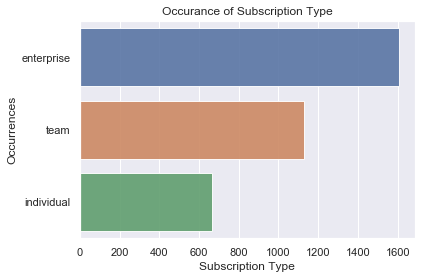

In [313]:
sns.set(style="darkgrid")
sns.barplot(subs_count.values,subs_count.index, alpha=0.9)
plt.title('Occurance of Subscription Type')
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Subscription Type', fontsize=12)
plt.show()

In [314]:
# most number of enterprise accounts 

In [315]:
# lets observe subscription wise arr 
sub_arr=account_acct_assgn_train.groupby(["start_subscription_type"]).agg({'expansion_arr':'sum'}).reset_index()
sub_arr['expansion_arr'] = sub_arr['expansion_arr'].apply(lambda x: '{:.2f}'.format(x)) # formatting values to decimal
sub_arr


,start_subscription_type,expansion_arr
0,enterprise,8989848.45
1,individual,10100.00
2,team,491041.57


mostly enterprise is high arr in comparision to individual and team
this can be due to enterprise being highly priced 

In [317]:
# plot quater wise expansion_arr
account_acct_assgn_train_2017 = account_acct_assgn_train.loc[account_acct_assgn_train['year']==2017].groupby(['rep_id']).agg({'expansion_arr': ['mean', 'median']})
account_acct_assgn_train_2018 = account_acct_assgn_train.loc[account_acct_assgn_train['year']==2018].groupby(['rep_id']).agg({'expansion_arr': ['mean', 'median']})
account_acct_assgn_train_2019 = account_acct_assgn_train.loc[account_acct_assgn_train['year']==2019].groupby(['rep_id']).agg({'expansion_arr': ['mean', 'median']})
account_acct_assgn_train_2020 = account_acct_assgn_train.loc[account_acct_assgn_train['year']==2020].groupby(['rep_id']).agg({'expansion_arr': ['mean', 'median']})


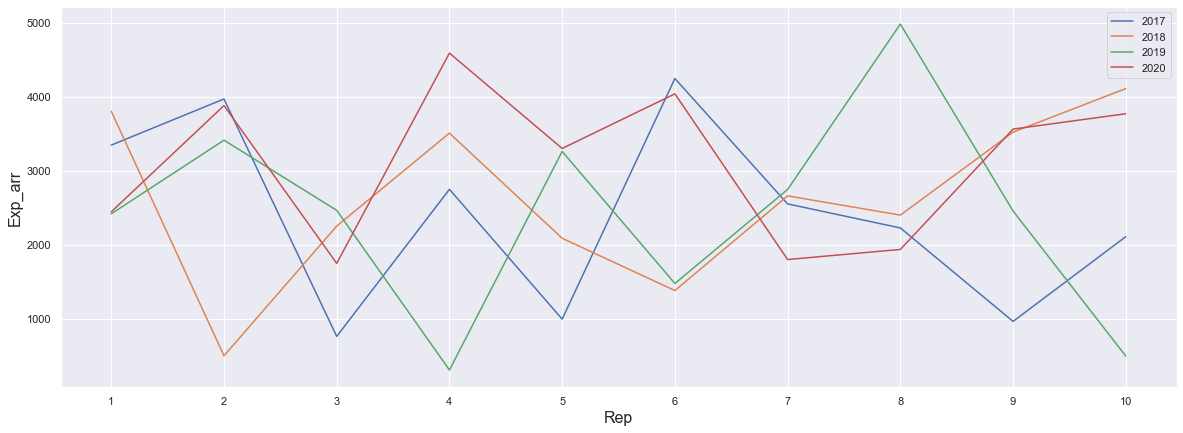

In [318]:
plt.figure(figsize=(20, 7))
sns.lineplot(account_acct_assgn_train_2017['expansion_arr']['mean'].index, account_acct_assgn_train_2017['expansion_arr']['mean'].values)
sns.lineplot(account_acct_assgn_train_2018['expansion_arr']['mean'].index, account_acct_assgn_train_2018['expansion_arr']['mean'].values)
sns.lineplot(account_acct_assgn_train_2019['expansion_arr']['mean'].index, account_acct_assgn_train_2019['expansion_arr']['mean'].values)
sns.lineplot(account_acct_assgn_train_2020['expansion_arr']['mean'].index, account_acct_assgn_train_2020['expansion_arr']['mean'].values)

plt.xticks(np.arange(1, 11, step=1))
plt.legend(['2017', '2018', '2019','2020'])

plt.ylabel('Exp_arr', fontsize=16)
plt.xlabel('Rep', fontsize=16)
plt.show()

2020 was good year for reps and also no rep performs consistently well for all 4 years, yes reps 1, 3 and 7 has 
less variable performance (stablilty in expansion_arr) than others yet its evident no rep consistently performing well. 

In [320]:
# plot quater wise expansion_arr
account_acct_assgn_train_q1 = account_acct_assgn_train.loc[account_acct_assgn_train['quarter']==1].groupby(['rep_id']).agg({'expansion_arr': ['mean', 'median']})
account_acct_assgn_train_q2= account_acct_assgn_train.loc[account_acct_assgn_train['quarter']==2].groupby(['rep_id']).agg({'expansion_arr': ['mean', 'median']})
account_acct_assgn_train_q3 = account_acct_assgn_train.loc[account_acct_assgn_train['quarter']==3].groupby(['rep_id']).agg({'expansion_arr': ['mean', 'median']})
account_acct_assgn_train_q4 = account_acct_assgn_train.loc[account_acct_assgn_train['quarter']==4].groupby(['rep_id']).agg({'expansion_arr': ['mean', 'median']})


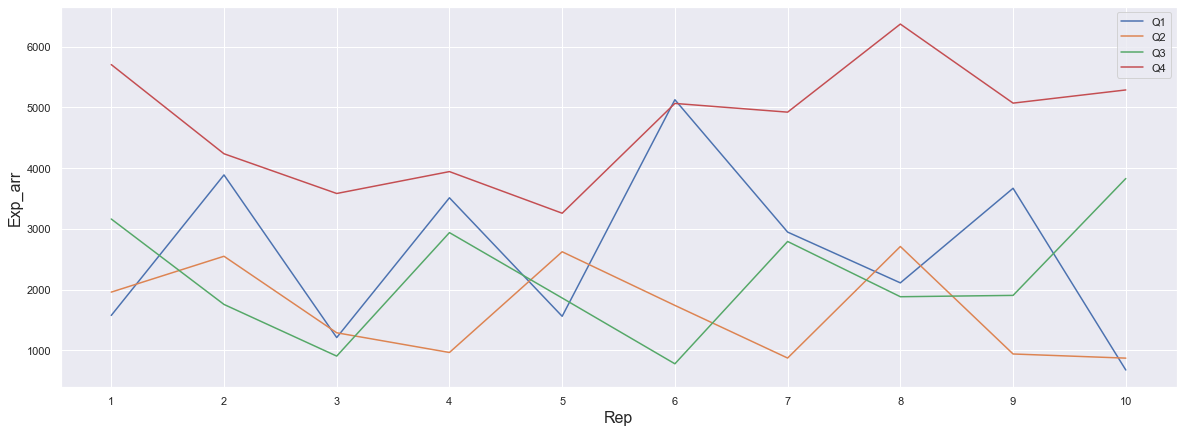

In [321]:
plt.figure(figsize=(20, 7))
sns.lineplot(account_acct_assgn_train_q1['expansion_arr']['mean'].index, account_acct_assgn_train_q1['expansion_arr']['mean'].values)
sns.lineplot(account_acct_assgn_train_q2['expansion_arr']['mean'].index, account_acct_assgn_train_q2['expansion_arr']['mean'].values)
sns.lineplot(account_acct_assgn_train_q3['expansion_arr']['mean'].index, account_acct_assgn_train_q3['expansion_arr']['mean'].values)
sns.lineplot(account_acct_assgn_train_q4['expansion_arr']['mean'].index, account_acct_assgn_train_q4['expansion_arr']['mean'].values)

plt.xticks(np.arange(1, 11, step=1))
plt.legend(['Q1', 'Q2', 'Q3','Q4'])

plt.ylabel('Exp_arr', fontsize=16)
plt.xlabel('Rep', fontsize=16)
plt.show()

Quarter 2 is worst for every rep and quarter 4 is good among all.

In [322]:
quarter_anlysis=account_acct_assgn_train.groupby(["quarter"]).agg({'expansion_arr':'sum'}).reset_index().sort_values(by='quarter')

In [323]:
# for graph purposes 
quarter_anlysis["quarter"]= quarter_anlysis["quarter"].astype(str)

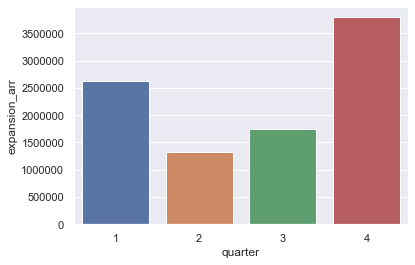

In [324]:
sns.barplot(x="quarter",y="expansion_arr",data=quarter_anlysis)
# overall for all reps quarter 4 is 

Lets start to model now

In [325]:
# now we dont need date variable in both of our train and test
account_acct_assgn_train=account_acct_assgn_train.drop(['Date'],axis=1)
account_acct_assgn_tst=account_acct_assgn_tst.drop(['Date'],axis=1)

In [326]:
account_acct_assgn_train_grp = account_acct_assgn_train.groupby(["rep_id", "quarter", "year",
     "start_subscription_type"]).agg({'expansion_arr':'sum'}).reset_index().sort_values(by='rep_id')

In [327]:
account_acct_assgn_tst_grp = account_acct_assgn_tst.groupby(["rep_id", "quarter", "year",
     "start_subscription_type"]).agg({'expansion_arr':'sum'}).reset_index().sort_values(by='rep_id')

In [328]:
account_acct_assgn_train_grp.head(15)

,rep_id,quarter,year,start_subscription_type,expansion_arr
0,1,1,2017,enterprise,0.000000
28,1,3,2017,individual,300.000000
29,1,3,2017,team,106.735629
30,1,3,2018,enterprise,156066.400535
31,1,3,2018,individual,0.000000
32,1,3,2018,team,3048.029866
33,1,3,2019,enterprise,0.000000
34,1,3,2019,individual,200.000000
35,1,3,2019,team,3660.802022
36,1,3,2020,enterprise,25540.895726


In [329]:
account_acct_assgn_tst_grp.head(4)

,rep_id,quarter,year,start_subscription_type,expansion_arr
0,1,2,2021,enterprise,0.0
1,1,2,2021,individual,0.0
2,1,2,2021,team,0.0
3,2,2,2021,enterprise,0.0


In [267]:
# we if need to get objective goals which are equitable, 
# as for rep level goals for reps all their subs accounts will be taken to define goal for q2 2021

In [270]:
## convert the subs type levels into code 0,1,2

In [330]:
account_acct_assgn_train_grp[['start_subscription_type']] = account_acct_assgn_train_grp[['start_subscription_type']].apply(lambda col:pd.Categorical(col).codes)

In [331]:
account_acct_assgn_tst_grp[['start_subscription_type']] = account_acct_assgn_tst_grp[['start_subscription_type']].apply(lambda col:pd.Categorical(col).codes)

In [332]:
cols = account_acct_assgn_train_grp.columns
cols1= account_acct_assgn_tst_grp.columns

In [333]:
account_acct_assgn_train_grp[cols] = account_acct_assgn_train_grp[cols].apply(pd.to_numeric, errors='coerce')

In [334]:
account_acct_assgn_tst_grp[cols1] = account_acct_assgn_tst_grp[cols1].apply(pd.to_numeric, errors='coerce')

In [335]:
y_train = account_acct_assgn_train_grp.loc[:, ['expansion_arr']]
x_train = account_acct_assgn_train_grp.drop(['expansion_arr'], axis=1)

In [336]:
y_test = account_acct_assgn_tst_grp.loc[:, ['expansion_arr']]
x_test = account_acct_assgn_tst_grp.drop(['expansion_arr'], axis=1)

In [337]:
clf = RandomForestRegressor(random_state=0)

pipe = Pipeline(steps=[('clf', clf)])

param_grid_rf = [ {
                'clf':[RandomForestRegressor()],
                'clf__n_estimators': [140,150,160],
                'clf__max_depth': [25,30,35],
                'clf__max_features': ['auto',5,6]
                }
              ]

gscv_rf1 = GridSearchCV(pipe, param_grid_rf, cv = 3, n_jobs=-1)
model_rf1 = gscv_rf1.fit(x_train, y_train)

/Users/shaivya/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [338]:
y_pred_rf = gscv_rf1.best_estimator_.predict(x_test)

In [339]:
# RMSE and rsquared 
#print(np.sqrt(mean_squared_error(y_test,y_pred_rf)))

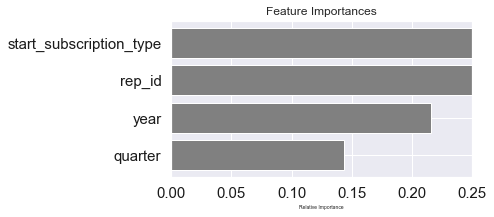

In [340]:
plt.rcParams["figure.figsize"] = (5,3)

importances = gscv_rf1.best_estimator_._final_estimator.feature_importances_

attributes = list(x_train.columns)
indices = np.argsort(importances)
attributes_rank = []
for i in indices:
    attributes_rank.append(attributes[i])
plt.title('Feature Importances')
plt.tight_layout()
plt.barh(range(len(indices)), importances[indices], color='gray', align='center')
plt.yticks(range(len(indices)), attributes_rank, fontsize=5)
plt.xlabel('Relative Importance',fontsize=5)
plt.xticks(color='k', size=15)
plt.yticks(color='k', size=15)
plt.xlim([0.0, 0.25])
plt.show()

In [341]:
account_acct_assgn_tst_grp = account_acct_assgn_tst_grp.sort_values(['rep_id'], ascending=[True])
account_acct_assgn_tst_grp['expansion_arr'] = y_pred_rf
account_acct_assgn_tst_grp.head(10)

,rep_id,quarter,year,start_subscription_type,expansion_arr
0,1,2,2021,0,67770.821059
1,1,2,2021,1,142.857143
2,1,2,2021,2,2206.763264
3,2,2,2021,0,89438.404980
4,2,2,2021,1,41.428571
5,2,2,2021,2,5318.208305
6,3,2,2021,0,35592.461024
7,3,2,2021,1,288.571429
8,3,2,2021,2,2599.033826
9,4,2,2021,0,61692.029912


In [342]:
# rep levels goal can de decided like this and the objective will be to make it or beat this!!!

In [381]:
eachreptr=account_acct_assgn_tst_grp.groupby(["rep_id"]).agg({'expansion_arr':'mean'}).reset_index().sort_values(by='rep_id')

In [382]:
eachreptr

,rep_id,expansion_arr
0,1,23373.480488
1,2,31599.347286
2,3,12826.688759
3,4,21129.164882
4,5,10708.624798
5,6,54895.337068
6,7,65191.708499
7,8,56855.322693
8,9,48253.589807
9,10,23830.812929


We have now each rep goal for next quarter 
From this we can decide on a threshold values say (10,700=min value) arr in next quarter rep makes or beat it to get incentive
(similar to saying if you get a 4 and above rating on scale of 5 you are eligible for bonus)

# Looking at Teams

In [113]:
# make a lookup for representative and its team
rep_teams=pd.merge(reps,teams,on='team_id',how='left')

In [114]:
rep_teams

,rep_id,rep_name,team_id,team_name
0,1,Adam,1,West
1,2,Brittany,1,West
2,3,Carson,1,West
3,4,Danielle,1,West
4,5,Ethan,2,Central
5,6,Felicity,2,Central
6,7,Gregory,2,Central
7,8,Harriet,3,East
8,9,Isaac,3,East
9,10,Jacqueline,3,East


In [115]:
teamlvl=pd.merge(account_acct_assgn,rep_teams,on='rep_id',how='left')

In [116]:
teamlvl

,account_id,Date,start_subscription_type,start_arr,expansion_arr,rep_id,year,quarter,rep_name,team_id,team_name
0,1,2017-01-01,team,8172.226700,0.0,1,2017,1,Adam,1,West
1,1,2017-04-01,team,8172.226700,0.0,1,2017,2,Adam,1,West
2,1,2017-07-01,team,8172.226700,0.0,1,2017,3,Adam,1,West
3,1,2017-10-01,team,8172.226700,0.0,1,2017,4,Adam,1,West
4,1,2018-01-01,team,8172.226700,0.0,1,2018,1,Adam,1,West
...,...,...,...,...,...,...,...,...,...,...,...
3595,200,2020-04-01,enterprise,231202.606738,0.0,10,2020,2,Jacqueline,3,East
3596,200,2020-07-01,team,231202.606738,0.0,10,2020,3,Jacqueline,3,East
3597,200,2020-10-01,team,6864.543108,0.0,10,2020,4,Jacqueline,3,East
3598,200,2021-01-01,team,6864.543108,0.0,10,2021,1,Jacqueline,3,East


In [117]:
teamlvl_train = teamlvl[(teamlvl['Date'] != "2021-04-01")]

In [118]:
teamlvl_tst = teamlvl[(teamlvl['Date'] == "2021-04-01")]

In [119]:
teamlvl_train=teamlvl_train.drop(['Date'],axis=1)
teamlvl_tst=teamlvl_tst.drop(['Date'],axis=1)

### Graphs

In [120]:
teamlvl_train_q1 = teamlvl_train.loc[teamlvl_train['quarter']==1].groupby(['team_id']).agg({'expansion_arr': ['mean', 'median']})
teamlvl_train_q2= teamlvl_train.loc[teamlvl_train['quarter']==2].groupby(['team_id']).agg({'expansion_arr': ['mean', 'median']})
teamlvl_train_q3 = teamlvl_train.loc[teamlvl_train['quarter']==3].groupby(['team_id']).agg({'expansion_arr': ['mean', 'median']})
teamlvl_train_q4 = teamlvl_train.loc[teamlvl_train['quarter']==4].groupby(['team_id']).agg({'expansion_arr': ['mean', 'median']})


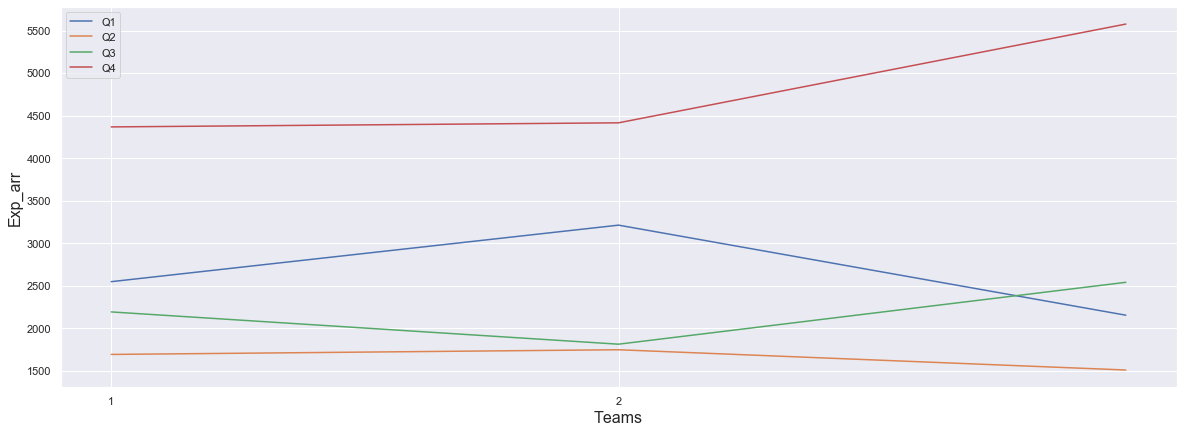

In [121]:
plt.figure(figsize=(20, 7))
sns.lineplot(teamlvl_train_q1['expansion_arr']['mean'].index, teamlvl_train_q1['expansion_arr']['mean'].values)
sns.lineplot(teamlvl_train_q2['expansion_arr']['mean'].index, teamlvl_train_q2['expansion_arr']['mean'].values)
sns.lineplot(teamlvl_train_q3['expansion_arr']['mean'].index, teamlvl_train_q3['expansion_arr']['mean'].values)
sns.lineplot(teamlvl_train_q4['expansion_arr']['mean'].index, teamlvl_train_q4['expansion_arr']['mean'].values)

plt.xticks(np.arange(1, 3, step=1))
plt.legend(['Q1', 'Q2', 'Q3','Q4'])

plt.ylabel('Exp_arr', fontsize=16)
plt.xlabel('Teams', fontsize=16)
plt.show()

In [122]:
team_sub = teamlvl_train.groupby(["team_id",
      "start_subscription_type"]).agg({'expansion_arr':'sum'}).reset_index().sort_values(by='team_id')

In [123]:
team_sub['expansion_arr'] = team_sub['expansion_arr'].apply(lambda x: '{:.2f}'.format(x)) # formatting values to decimal
team_sub

,team_id,start_subscription_type,expansion_arr
0,1,enterprise,3485804.41
1,1,individual,4900.00
2,1,team,167819.61
3,2,enterprise,2742833.96
4,2,individual,2400.00
5,2,team,131766.47
6,3,enterprise,2761210.07
7,3,individual,2800.00
8,3,team,191455.48


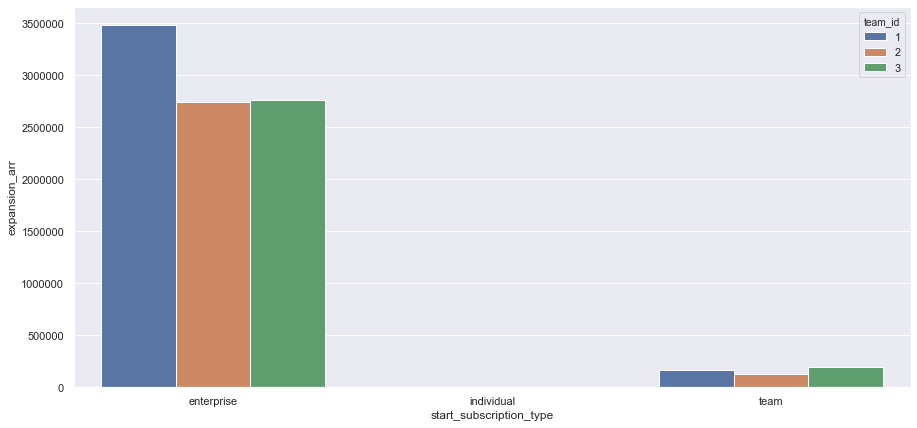

In [124]:
plt.figure(figsize=(15, 7))
sns.barplot(x = "start_subscription_type", y = "expansion_arr", hue = "team_id",data = team_sub)
plt.show()

In [125]:
## aggregating data at team id, quarter and year and also subs type 
teamlvl_train_grp = teamlvl_train.groupby(["team_id", "quarter", "year",
      "start_subscription_type"]).agg({'expansion_arr':'sum'}).reset_index().sort_values(by='team_id')

In [126]:
teamlvl_train_grp.head(160)

,team_id,quarter,year,start_subscription_type,expansion_arr
0,1,1,2017,enterprise,139560.510716
28,1,3,2017,individual,300.000000
29,1,3,2017,team,3121.721743
30,1,3,2018,enterprise,224194.092578
31,1,3,2018,individual,300.000000
...,...,...,...,...,...
122,3,2,2018,team,5992.119448
123,3,2,2019,enterprise,90825.268395
124,3,2,2019,individual,200.000000
126,3,2,2020,enterprise,0.000000


In [127]:
#sns.kdeplot(teamlvl_train_grp['expansion_arr'])

### Model

In [128]:
# tst cases 
teamlvl_tst_grp = teamlvl_tst.groupby(["team_id", "quarter", "year",
      "start_subscription_type"]).agg({'expansion_arr':'sum'}).reset_index().sort_values(by='team_id')

In [129]:
## convert the subs type levels into code 0,1,2

In [130]:
teamlvl_train_grp[['start_subscription_type']] = teamlvl_train_grp[['start_subscription_type']].apply(lambda col:pd.Categorical(col).codes)

In [131]:
teamlvl_tst_grp[['start_subscription_type']] = teamlvl_tst_grp[['start_subscription_type']].apply(lambda col:pd.Categorical(col).codes)

In [132]:
colst = teamlvl_train_grp.columns
colst1= teamlvl_tst_grp.columns

In [133]:
teamlvl_train_grp[colst] = teamlvl_train_grp[colst].apply(pd.to_numeric, errors='coerce')

In [134]:
teamlvl_tst_grp[colst1] = teamlvl_tst_grp[colst1].apply(pd.to_numeric, errors='coerce')

In [135]:
y_traint = teamlvl_train_grp.loc[:, ['expansion_arr']]
x_traint = teamlvl_train_grp.drop(['expansion_arr'], axis=1)

In [136]:
y_testt = teamlvl_tst_grp.loc[:, ['expansion_arr']]
x_testt = teamlvl_tst_grp.drop(['expansion_arr'], axis=1)

In [137]:
### model

In [138]:
clf = RandomForestRegressor(random_state=0)

pipe = Pipeline(steps=[('clf', clf)])

param_grid_rf = [ {
                'clf':[RandomForestRegressor()],
                'clf__n_estimators': [140,150,160],
                'clf__max_depth': [25,30,35],
                'clf__max_features': ['auto',5,6]
                }
              ]

gscv_rf1t = GridSearchCV(pipe, param_grid_rf, cv = 3, n_jobs=-1)
model_rf1t = gscv_rf1t.fit(x_traint, y_traint)

/Users/shaivya/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [139]:
y_pred_rf = gscv_rf1t.best_estimator_.predict(x_testt)

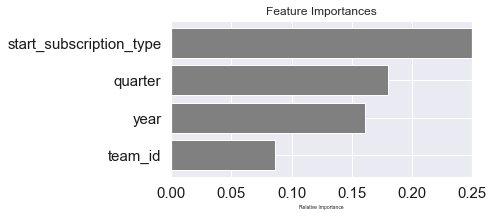

In [140]:
plt.rcParams["figure.figsize"] = (5,3)

importances = gscv_rf1t.best_estimator_._final_estimator.feature_importances_

attributes = list(x_traint.columns)
indices = np.argsort(importances)
attributes_rank = []
for i in indices:
    attributes_rank.append(attributes[i])
plt.title('Feature Importances')
plt.tight_layout()
plt.barh(range(len(indices)), importances[indices], color='gray', align='center')
plt.yticks(range(len(indices)), attributes_rank, fontsize=5)
plt.xlabel('Relative Importance',fontsize=5)
plt.xticks(color='k', size=15)
plt.yticks(color='k', size=15)
plt.xlim([0.0, 0.25])
plt.show()

In [141]:
teamlvl_tst_grp = teamlvl_tst_grp.sort_values(['team_id'], ascending=[True])
teamlvl_tst_grp['expansion_arr'] = y_pred_rf
#teamlvl_tst_grp.head(10)

,team_id,quarter,year,start_subscription_type,expansion_arr
0,1,2,2021,0,297775.944012
1,1,2,2021,1,413.125000
2,1,2,2021,2,8934.016809
3,2,2,2021,0,359363.999986
4,2,2,2021,1,180.000000
5,2,2,2021,2,5225.096039
6,3,2,2021,0,313547.907459
7,3,2,2021,1,342.500000
8,3,2,2021,2,12716.783461


In [409]:
eachtmtr=teamlvl_tst_grp.groupby(["team_id","quarter","year"]).agg({'expansion_arr':'mean'}).reset_index().sort_values(by='team_id')

In [410]:
eachtmtr

,team_id,quarter,year,expansion_arr
0,1,2,2021,102374.361941
1,2,2,2021,121589.698675
2,3,2,2021,108869.063640


In [411]:
eachtmod=teamlvl_train_grp.groupby(["team_id","quarter","year"]).agg({'expansion_arr':'sum'}).reset_index().sort_values(by='team_id')

In [412]:
eachtmod.head()

,team_id,quarter,year,expansion_arr
0,1,1,2017,150061.914372
16,1,4,2020,384159.045258
15,1,4,2019,156083.262662
14,1,4,2018,383484.801923
13,1,4,2017,473649.818529


In [413]:
## Assuming all 3 teams have no influence of geographical benifits or disbenifits 
## and knowing quarter performs less better than other quarters we can keep a level of min of all 
## 307100 as a team overall target to look for in this quarter also because 2020 

In [414]:
## this number of expansion arr can be comparitive to look at other year total arr 

### Aggregate 

In [415]:
# team 1 has 4 representative 
# team 2 has 3 representative
# team 3 has 3 representative

In [416]:
rep_teams

,rep_id,rep_name,team_id,team_name
0,1,Adam,1,West
1,2,Brittany,1,West
2,3,Carson,1,West
3,4,Danielle,1,West
4,5,Ethan,2,Central
5,6,Felicity,2,Central
6,7,Gregory,2,Central
7,8,Harriet,3,East
8,9,Isaac,3,East
9,10,Jacqueline,3,East


In [417]:
# assuming no external factors affecting team productivity 
# being equitable assuming as team you achieve goals 

In [418]:
eachtmtr

,team_id,quarter,year,expansion_arr
0,1,2,2021,102374.361941
1,2,2,2021,121589.698675
2,3,2,2021,108869.063640


In [421]:
def my_fun(x, var1, var2, var3):
    #print (x)
    if x[var1]==1:
        x[var3]=x[var2]/4
    else:
        x[var3]=x[var2]/3
    return x    

In [422]:
eachtmtr=eachtmtr.apply(lambda x: my_fun(x, 'team_id', 'expansion_arr','rep_expansion_arr'), axis=1)

In [430]:
eachtmtr["team_id"]= eachtmtr["team_id"].astype(int)
eachtmtr["quarter"]= eachtmtr["quarter"].astype(int)
eachtmtr["year"]= eachtmtr["year"].astype(int)

In [431]:
tbl1=pd.merge(eachreptr,rep_teams,on='rep_id',how='left')

In [432]:
aggtb=pd.merge(tbl1,eachtmtr,on="team_id",how="left")

In [435]:
aggtb.drop(['expansion_arr_y','team_name'], axis = 1) 

,rep_id,expansion_arr_x,rep_name,team_id,quarter,year,rep_expansion_arr
0,1,23373.480488,Adam,1,2,2021,25593.590485
1,2,31599.347286,Brittany,1,2,2021,25593.590485
2,3,12826.688759,Carson,1,2,2021,25593.590485
3,4,21129.164882,Danielle,1,2,2021,25593.590485
4,5,10708.624798,Ethan,2,2,2021,40529.899558
5,6,54895.337068,Felicity,2,2,2021,40529.899558
6,7,65191.708499,Gregory,2,2,2021,40529.899558
7,8,56855.322693,Harriet,3,2,2021,36289.687880
8,9,48253.589807,Isaac,3,2,2021,36289.687880
9,10,23830.812929,Jacqueline,3,2,2021,36289.687880


In [ ]:
So aggregate goals will be that each rep achieve their respective goals and also their team goal. 